In [26]:
%matplotlib notebook
import numpy as np
import emlddmm
import json
import nrrd
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [ ]:
# code to do
# common interface for load images
# command line interface
# preprocessing (here we are doing downsampling)
# apply transforms to other data

# release to do
# readme page
# lisence
# documentation

In [9]:
atlas_name = '/home/dtward/data/AllenInstitute/ara_nissl/ara_nissl_50.nrrd'
label_name = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
target_name = '../microscopy_v2/microscopy/'
config_file = 'config787.json'
output_dir = 'test_outputs/'

In [10]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downJs = config['downJ']

<IPython.core.display.Javascript object>


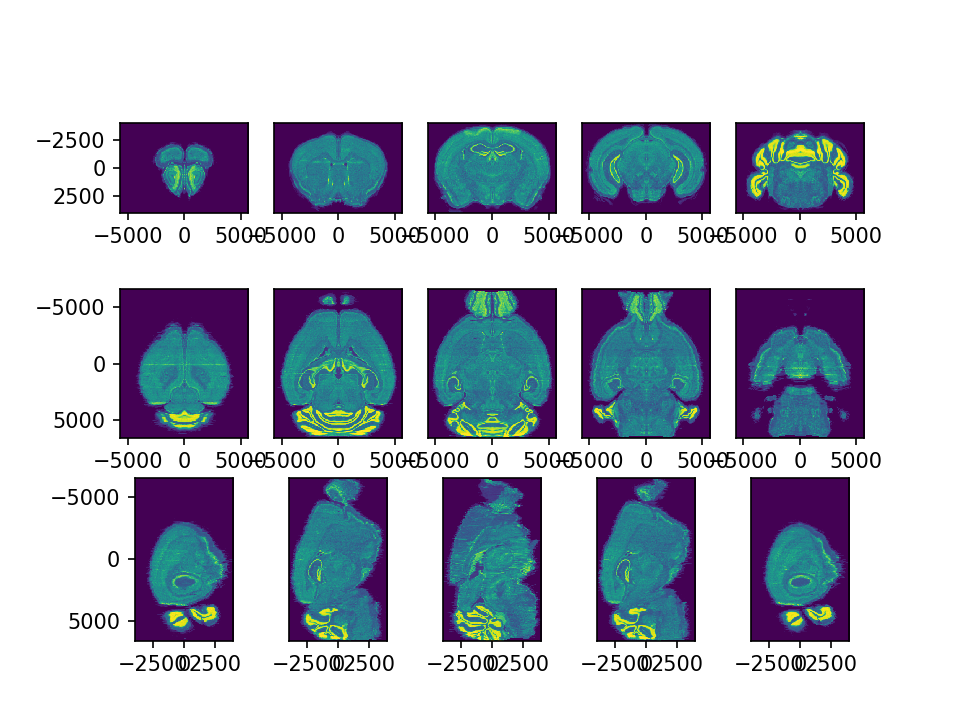

In [12]:
# load atlas
# TODO common loading function
I,hdr = nrrd.read(atlas_name)
I = I.astype(float)
I = I**0.5
I /= np.sqrt(np.mean(I**2))
I = I[None]
dI = np.diag(hdr['space directions']).astype(float)
nI = I.shape
xI = [np.arange(n)*d - (n-1)*d/2.0*0 for n,d in zip(nI[1:],dI)]
xI = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nI[1:],dI)]

S,hdr = nrrd.read(label_name)

fig = emlddmm.draw(I,xI)

loading target images


<IPython.core.display.Javascript object>


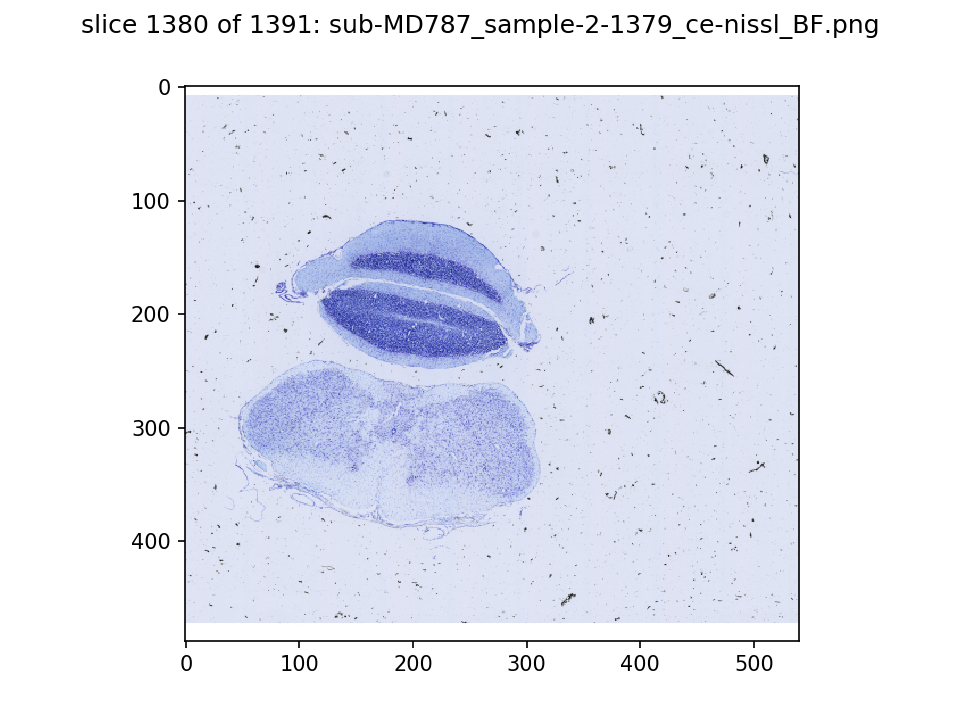

['sample_id', 'participant_id', 'species', 'status', 'uuid']
padding and assembling into 3D volume


In [14]:
xJ,J,W0 = emlddmm.load_slices(target_name)
nJ = np.array(J.shape)
dJ = np.array([xJ[0][1]-xJ[0][0], xJ[1][1]-xJ[1][0],xJ[2][1]-xJ[2][0]])

In [31]:
# initial downsampling
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ (np.array(d)/mindownJ).astype(int) for d in downJs]
dJ = np.array((xJ[0][1]-xJ[0][0],xJ[1][1]-xJ[1][0],xJ[2][1]-xJ[2][0]))
nJ = np.array(J.shape,dtype=int)
config['downJ'] = downJs

dv tensor([150., 150., 150.], device='cuda:1')
a scale is 300.0


<IPython.core.display.Javascript object>


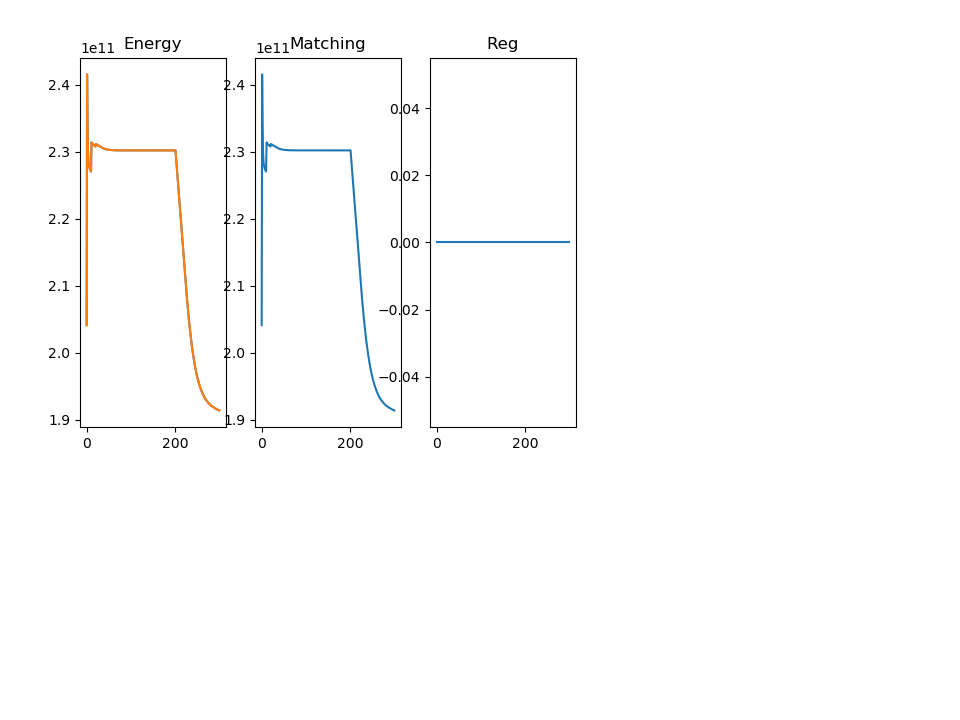

<IPython.core.display.Javascript object>


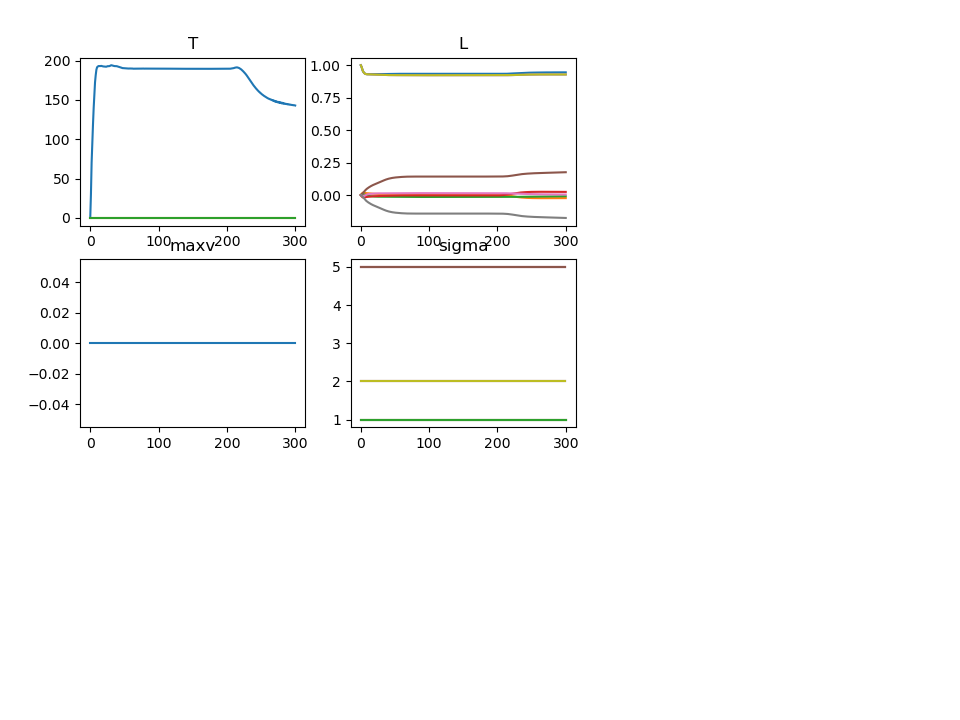

<IPython.core.display.Javascript object>


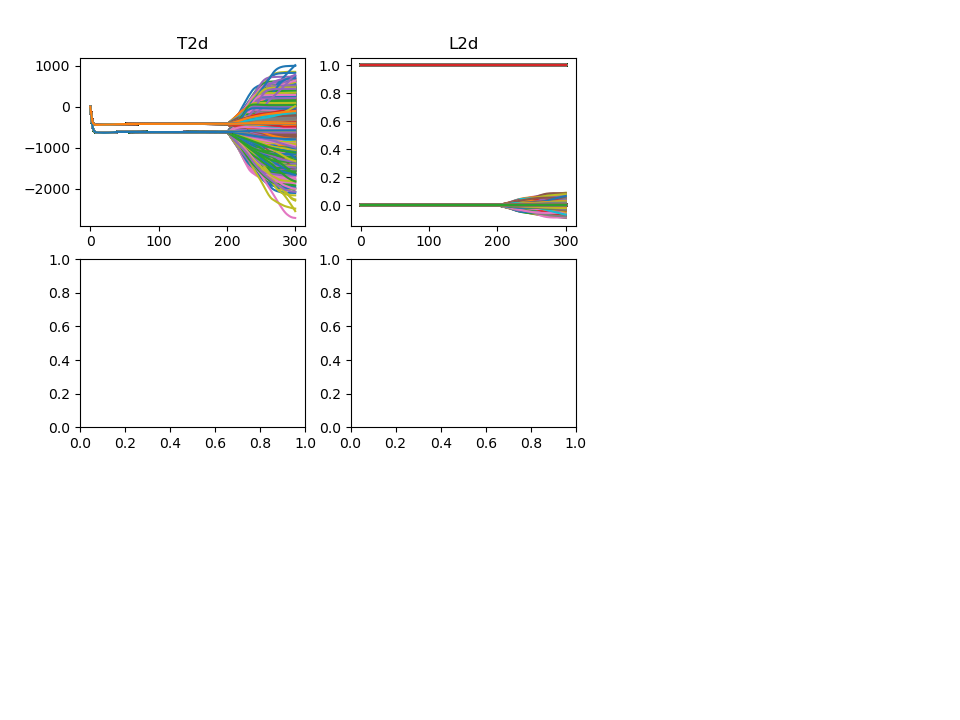

<IPython.core.display.Javascript object>


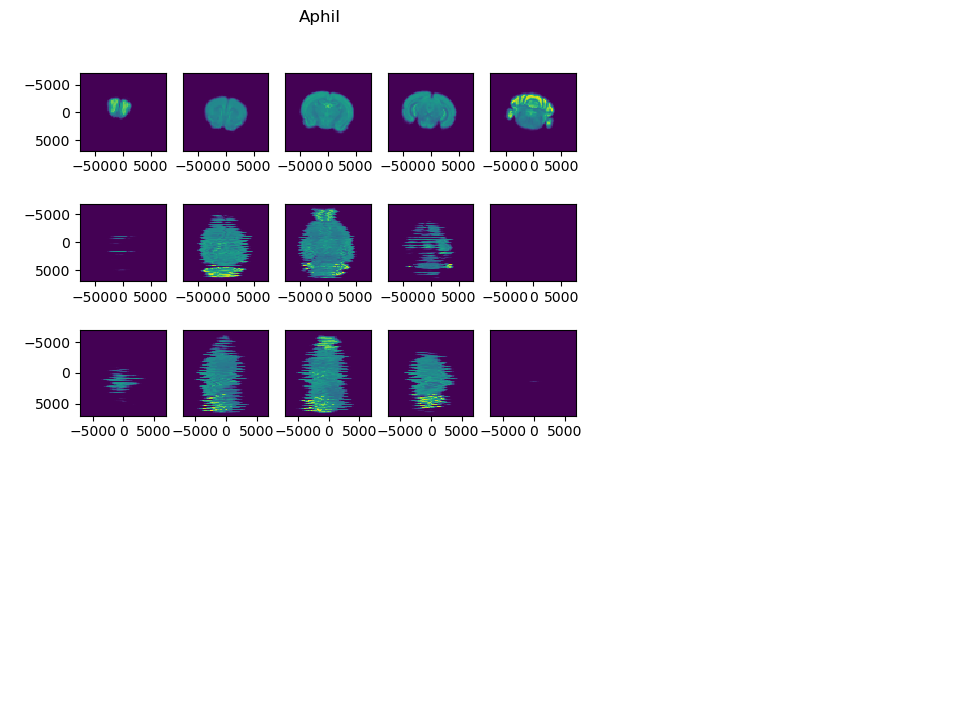

<IPython.core.display.Javascript object>


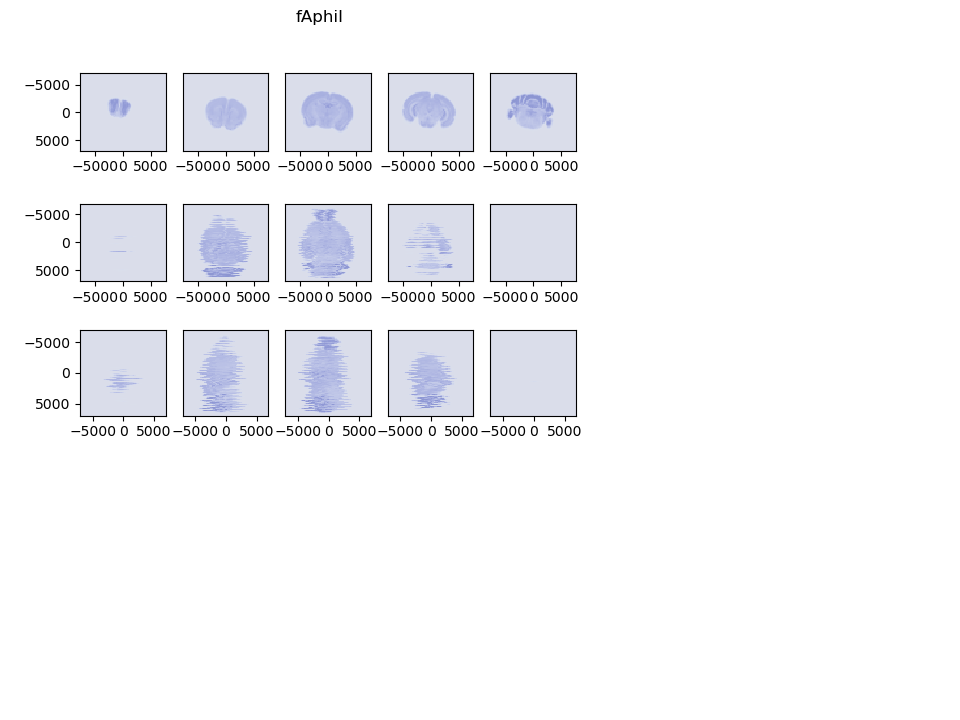

<IPython.core.display.Javascript object>


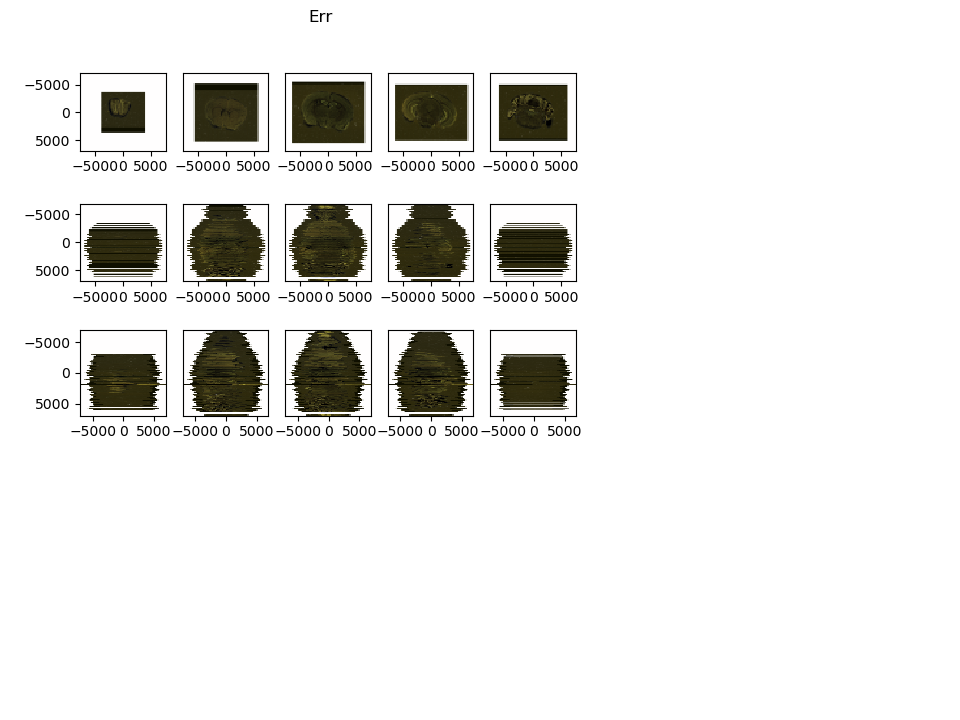

<IPython.core.display.Javascript object>


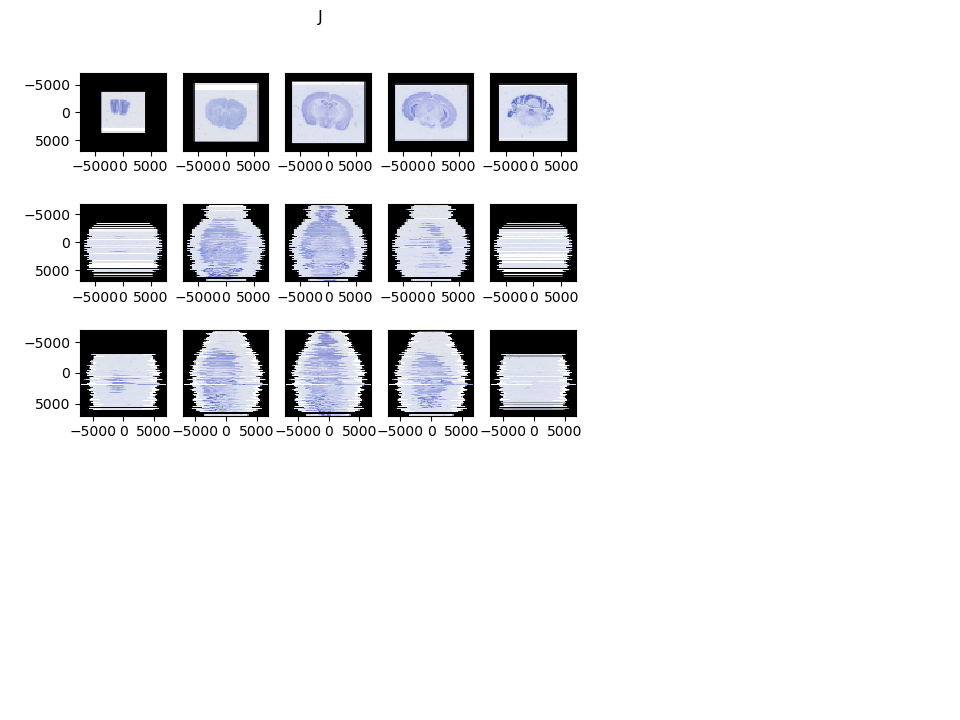

<IPython.core.display.Javascript object>


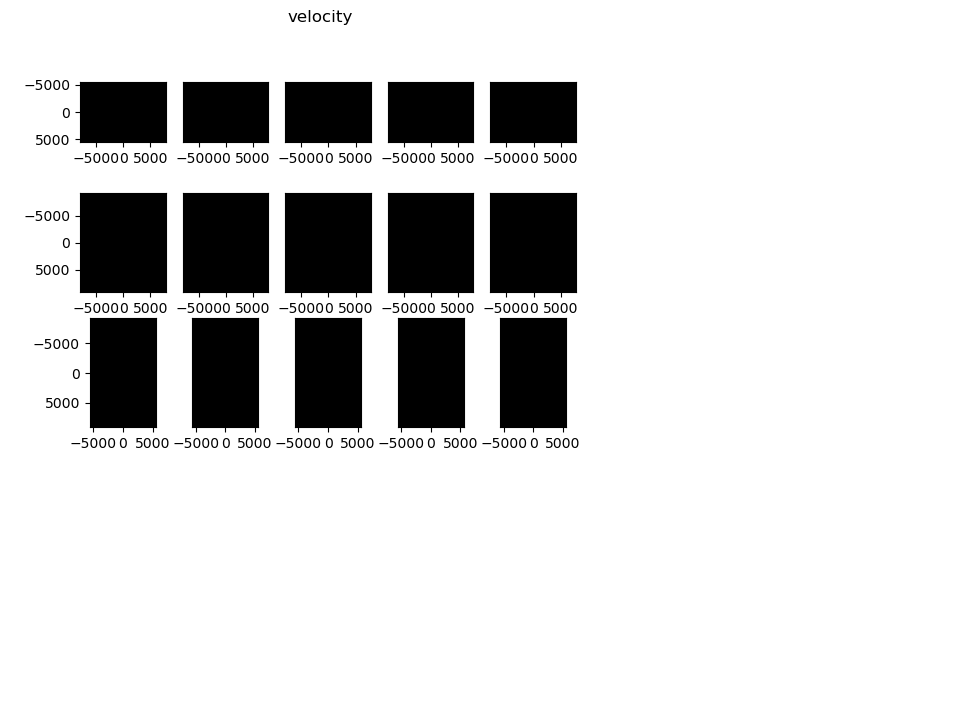

<IPython.core.display.Javascript object>


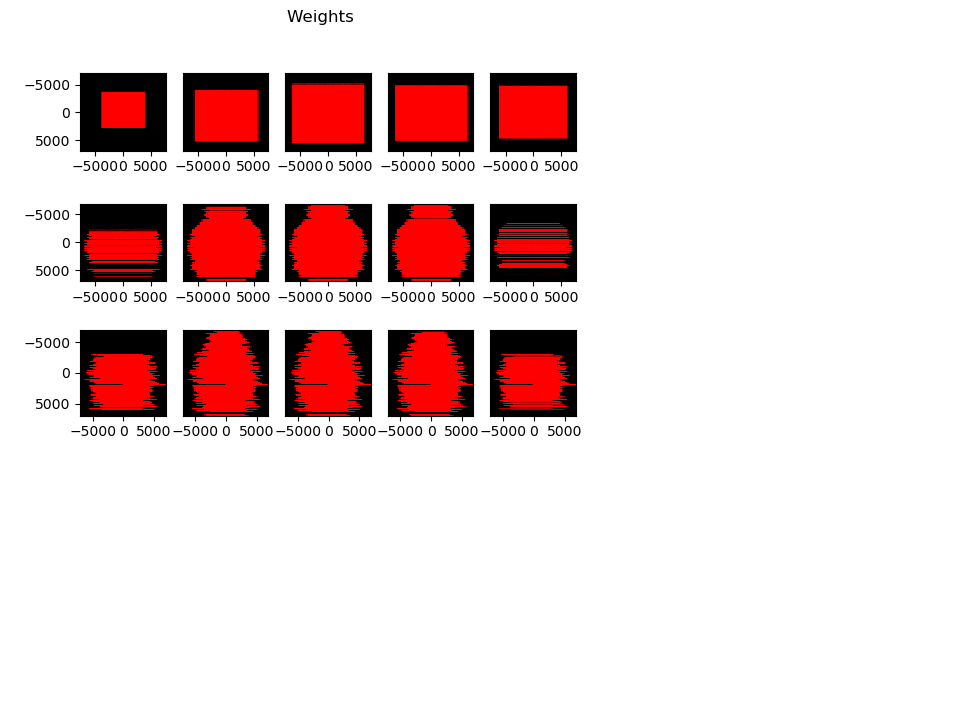

/mnt/data/csh_data/emlddmm/emlddmm.py:41: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Iteration 70, linear oscilating, reducing eA to 0.9
Finished iteration 70
Iteration 80, translation oscilating, reducing eA to 0.81
Finished iteration 80
Iteration 90, linear oscilating, reducing eA to 0.7290000000000001
Finished iteration 90
Iteration 100, linear oscilating, reducing eA to 0.6561000000000001
Finished iteration 100
Iteration 110, linear oscilating, reducing eA to 0.5904900000000002
Finished iteration 110
Iteration 120, linear oscilating, reducing eA to 0.5314410000000002
Finished iteration 120
Iteration 130, translation oscilating, reducing eA to 0.47829690000000014
Finished iteration 130
Iteration 140, linear oscilating, reducing eA to 0.43046721000000016
Finished iteration 140
Finished iteration 150
Iteration 160, linear oscilating, reducing eA to 0.38742048900000015
Finished iteration 160
Iteration 170, linear oscil

In [ ]:
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device='cuda:1',**config)

In [ ]:
write_transform_outputs(output_dir,output)

In [ ]:
write_qc_outputs(output_dir,output,xI,I,xJ,J,xS=xI,S=S)